In [68]:
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_datetime64_any_dtype

vessel_positions = pd.read_csv('data/vessel_positions.csv')
vessel_characteristics = pd.read_csv('data/vessel_characteristics.csv')

/var/folders/xh/nn_nv4352_7943f1nq_d3myc0000gn/T/ipykernel_95420/1605837903.py:5: DtypeWarning:

Columns (13,14,20,21,25,26,29,30,32,51) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/xh/nn_nv4352_7943f1nq_d3myc0000gn/T/ipykernel_95420/1605837903.py:6: DtypeWarning:

Columns (42,47,72,81,154,163,210) have mixed types. Specify dtype option on import or set low_memory=False.



In [69]:
'''
Convert a column that mixes Excel-serial numbers and “DD/MM/YYYY HH:MM” strings into one UTC-timestamp Series.
Rounds timings to the nearest second.

Returns unchanged if the column is already a datatime dtype. Otherwise, returns a Series of dtype datetime64[ns, UTC]; unparseable rows become NaT.
'''

def to_timestamp(dataframe, column_name):

    s = dataframe[column_name]

    if is_datetime64_any_dtype(s):
        return s

    numbers = pd.to_numeric(s, errors="coerce") # floats where possible, NaN otherwise
    dt1 = pd.to_datetime(numbers, unit="D", origin="1899-12-30", utc=True, errors="coerce") # convert floats to timestamps

    dates = s[numbers.isna()] # take the non-numeric rows

    # convert dates to timestamps
    dt2 = pd.to_datetime(dates, format="%d/%m/%Y %H:%M", dayfirst=True, utc=True, errors="coerce")

    final_column = dt1.fillna(dt2) # merge dt1 and dt2 into a single series of timestamps

    # round the timings to the nearest second
    final_column = final_column.dt.round('s')

    return final_column

The to_timestamp function is used convert datetime columns of string objects to datetime64[ns, UTC] dtype. This data type conversion provides accurate comparisons, date arithmetic, timezone handling, faster operations, less storage, and cleaner/built-in support (pandas and other libraries).

Four additional functions, object_to_string, float_to_Int64, std_to_boolean, and to_date, were implemented to convert columns from the default data types to the data types that suit the contents of each column best.

The strip_html function is used to clean axs_notes_dry column from <br> html elements.

All columns which were mistakenly altered to have the boolean data type because they were empty were adjusted back to the most suitable data type.

In [70]:
'''
Takes a dataframe, searches for text columns of object dtype and converts them to the string dtype.
Returns the modified dataframe.
'''

def object_to_string(dataframe):

    obj_cols = dataframe.select_dtypes(include=["object"]).columns

    for column in obj_cols:
        if all(isinstance(v, str) for v in dataframe[column].dropna()):
            dataframe[column] = dataframe[column].astype("string")

    return dataframe

In [71]:
'''
Takes a dataframe, searches for integer-like columns of float dtype and converts them to Pandas' Int64 dtype.
Returns the modified dataframe.
'''

def float_to_Int64(dataframe):

    float_cols = dataframe.select_dtypes(include=["float"]).columns

    for column in float_cols:
        if np.isclose(dataframe[column].dropna() % 1, 0).all():
            dataframe[column] = dataframe[column].astype("Int64")

    return dataframe

In [72]:
'''
Takes a dataframe, searches for columns of the integer data type that are boolean in nature and converts them to boolean dtype.
Standardizes boolean columns from 'Y'/'N' to True/False
Returns the modified dataframe.
'''

def std_to_boolean(dataframe):
    int_cols = dataframe.select_dtypes(include=["integer"]).columns

    for column in int_cols:
        if dataframe[column].dropna().isin([0, 1]).all():
            dataframe[column] = dataframe[column].astype("boolean")

    str_cols = dataframe.select_dtypes(include=["string"]).columns

    for column in str_cols:
        # Standardise to upper-case and strip whitespace once
        col_std = dataframe[column].dropna().str.strip().str.upper()

        if col_std.isin(["Y", "N"]).all():
            dataframe[column] = (
                dataframe[column].str.strip()
                   .str.upper()
                   .map({"Y": True, "N": False})
                   .astype("boolean")
            )

    return dataframe

In [73]:
'''
Takes a dataframe column of dates, converts it from object dtype to datetime dtype.
 Returns the modified column.
'''

def to_date(column):

    patterns = ["%d/%m/%Y", "%Y-%m-%d"]

    parsed = pd.Series(pd.NaT, index=column.index) # start all NaT

    for fmt in patterns:
        mask = parsed.isna() # rows still unparsed
        parsed.loc[mask] = pd.to_datetime(
            column.loc[mask],
            format=fmt,
            dayfirst=(fmt == "%d/%m/%Y"),
            errors="coerce"
        )

    return parsed

In [74]:
'''
Takes a dataframe column.
Removes <br>, <br/>, <br /> (case-insensitive) and collapse multiple spaces.
Returns the modified column.
'''

import pandas as pd
import re

def strip_html(column):
    return (
           column.str.replace(r"<br\s*/?>", " ", regex=True, flags=re.I)
           .str.replace(r"\s+", " ", regex=True)
           .str.strip()
    )

In [75]:
# vessel_positions data cleaning

# Convert datetime columns of string objects to datetime64[ns, UTC] dtype

datetime_cols = ['zone_entry_time', 'zone_out_time', 'port_entry_time',
        'port_out_time', 'operation_location_entry_time', 'operation_location_out_time',
        'waiting_zone_entry_time', 'waiting_zone_out_time', 'ais_eta', 'last_seen']

for col in datetime_cols:
    vessel_positions[col] = to_timestamp(vessel_positions, col)

date_cols = ['status_date_time', 'updated_at']

for col in date_cols:
    vessel_positions[col] = pd.to_datetime(vessel_positions[col], format="%d/%m/%Y", dayfirst=True, errors="coerce")

# Convert boolean in nature columns from integer dtype to boolean dtype
std_to_boolean(vessel_positions)

# Convert text columns from object dtype to string dtype
object_to_string(vessel_positions)

# Convert integer-like float columns to Int64
float_to_Int64(vessel_positions)

index      imo  vessel_dwt status_date_time  in_blackout  ais_speed  \
0          0  1014149       11717       2024-08-20        False        0.0   
1          1  1014163       39815       2024-08-20        False        0.0   
2          2  1014199       11722       2024-08-20        False        0.0   
3          3  1014254       13465       2024-08-20        False       11.8   
4          4  1014591       39415       2024-08-20        False       11.0   
...      ...      ...         ...              ...          ...        ...   
71630  71630  9978573      210870       2024-08-24        False        0.0   
71631  71631  9980174      181283       2024-08-24        False        8.0   
71632  71632  9980186      181283       2024-08-24        False       11.0   
71633  71633  9983578      182498       2024-08-24        False        0.0   
71634  71634  9989730      182316       2024-08-24        False       11.0   

       ais_draft  vessel_speed_ratio  ais_lat  ais_long  ...  \
0            5.1                 NaN  34.3504  133.8770  ...   
1            6.1                 NaN -33.8022  137.0520  ...   
2            4.4                 NaN  34.4042  133.4250  ...   
3            9.5                 NaN  11.7398  109.4890  ...   
4           10.6                 NaN  16.4267  113.8580  ...   
...          ...                 ...      ...       ...  ...   
71630        3.5                 NaN  34.4930  133.7310  ...   
71631       18.0                 NaN -31.5604   34.9163  ...   
71632       18.3                 NaN   2.0483  104.8680  ...   
71633        9.0                 NaN -21.2435  149.3020  ...   
71634       17.2                 NaN   6.8133   98.3317  ...   

      real_destination_country_name  real_destination_zone_id  \
0                             Japan                        73   
1                             China                        73   
2                             Japan                        73   
3                             Japan                        73   
4                              <NA>                      <NA>   
...                             ...                       ...   
71630                         Japan                        73   
71631                         Japan                        73   
71632                         China                        73   
71633                          <NA>                      <NA>   
71634                         India                        71   

      real_destination_zone_name vessel_operational_status  \
0                       Far East              waiting_load   
1                       Far East              at_port_load   
2                       Far East              waiting_load   
3                       Far East              at_sea_laden   
4                           <NA>              at_sea_laden   
...                          ...                       ...   
71630                   Far East       at_port_discharging   
71631                   Far East              at_sea_laden   
71632                   Far East              at_sea_laden   
71633                       <NA>              at_port_load   
71634           East Coast India              at_sea_laden   

      vessel_commodity_onboard vessel_commodity_group_onboard  \
0                         <NA>                           <NA>   
1                        Grain                          Grain   
2                         <NA>                           <NA>   
3                       Steels                         Steels   
4                       Steels                         Steels   
...                        ...                            ...   
71630                 Iron Ore                       Iron Ore   
71631                 Iron Ore                       Iron Ore   
71632                 Iron Ore                       Iron Ore   
71633              Coking Coal                           Coal   
71634              Coking Coal                           Coa

In [76]:
# vessel_characteristics data cleaning

# Convert datetime columns of string objects to datetime64[ns, UTC] dtype

datetime_cols = ['update_date']

for col in datetime_cols:
    vessel_characteristics[col] = to_timestamp(vessel_characteristics, col)

date_cols = ['built', 'demolition_date', 'keel_laying_date', 'launching_date', 'reported_date', 'cancelled_date', 'last_dd_date', 'next_dd_date', 'last_ss_date', 'next_ss_date', 'conversion_date']

for col in date_cols:
    vessel_characteristics[col] = to_date(vessel_characteristics[col])

# Convert text columns from object dtype to string dtype
object_to_string(vessel_characteristics)

# Convert integer-like float columns to Int64
float_to_Int64(vessel_characteristics)

# Convert boolean in nature columns from integer dtype to boolean dtype
# Separate open_hatches into categorical and boolean columns first

type_map = {
    "BOX":  "BOX",
    "OHBS": "OHBS",
    "Y":    "generic",
    "N":    "none"
}
vessel_characteristics["open_hatches"] = (
    vessel_characteristics["open_hatches"].map(type_map)
       .astype("category")
)

bool_map = {"BOX": True, "OHBS": True, "generic": True, "none": False}
bool_series = (
    vessel_characteristics["open_hatches"]
      .map(bool_map)
      .astype("boolean")
)

pos = vessel_characteristics.columns.get_loc("open_hatches")

vessel_characteristics.insert(
    loc=pos + 1,
    column="open_hatches_bool",
    value=bool_series
)

std_to_boolean(vessel_characteristics)

# return empty column to original dtype (or delete them)

vessel_characteristics["technical_manager"].astype("string")
vessel_characteristics["parent_shipowner"].astype("string")
vessel_characteristics["doc_holder"].astype("string")
vessel_characteristics["crew_manager"].astype("string")
vessel_characteristics["ism_manager"].astype("string")
vessel_characteristics["technical_manager_id"].astype("Int64")
vessel_characteristics["technical_manager_flag"].astype("string")
vessel_characteristics["technical_manager_flag_id"].astype("Int64")
vessel_characteristics["parent_shipowner_id"].astype("Int64")
vessel_characteristics["parent_shipowner_flag"].astype("string")
vessel_characteristics["parent_shipowner_flag_id"].astype("Int64")
vessel_characteristics["doc_holder_id"].astype("Int64")
vessel_characteristics["doc_holder_flag"].astype("string")
vessel_characteristics["doc_holder_flag_id"].astype("Int64")
vessel_characteristics["crew_manager_id"].astype("Int64")
vessel_characteristics["crew_manager_flag"].astype("string")
vessel_characteristics["crew_manager_flag_id"].astype("Int64")
vessel_characteristics["ism_manager_id"].astype("Int64")
vessel_characteristics["ism_manager_flag"].astype("string")
vessel_characteristics["ism_manager_flag_id"].astype("Int64")
vessel_characteristics["cranes_position"].astype("string")
vessel_characteristics["private_comments"].astype("string")
vessel_characteristics["private_tags"].astype("string")
vessel_characteristics["private_notes"].astype("string")

# strip the html tags from axs_notes_dry

vessel_characteristics["axs_notes_dry"] = strip_html(vessel_characteristics["axs_notes_dry"])

In [77]:
# Initial exploratory analysis

import plotly.express as px

sub_df = vessel_positions[['vessel_operational_status', 'ais_speed', 'ais_draft']].dropna()

display(sub_df.describe())

fig = px.scatter(
    sub_df,
    x='ais_draft',
    y='ais_speed',
    color='vessel_operational_status',
    opacity=0.55,
    labels={'ais_draft':"Draft [m]", 'ais_speed':"Speed over ground [kt]",
            'vessel_operational_status':"Operational status"},
    title="Speed vs Draft coloured by vessel operational status",
    hover_data=sub_df.columns
)
fig.update_traces(marker=dict(line=dict(width=0.4, color="white")))
fig.update_layout(legend=dict(itemsizing="constant", title=None,
                              orientation="v", yanchor="top", y=0.99))
fig.show()

fig_facet = px.scatter(
    sub_df,
    x='ais_draft',
    y='ais_speed',
    color='vessel_operational_status',
    facet_col='vessel_operational_status', facet_col_wrap=3,    # 3 panels per row ⇒ 5 rows for 14 cats
    opacity=0.55,
    labels={'ais_draft':"Draft [m]", 'ais_speed':"Speed over ground [kt]"},
    title="Speed–Draft relationship per operational status"
)
# wipe every subplot’s y-axis title
fig_facet.update_yaxes(title_text="")

fig_facet.layout.yaxis.title.text = "Speed over ground [kt]"

fig_facet.for_each_annotation(
    lambda a: a.update(text=a.text.split("=")[-1].replace("_"," "))
)

fig_facet.update_traces(marker=dict(line=dict(width=0.4, color="white")))
fig_facet.show()

ais_speed     ais_draft
count  71581.000000  71581.000000
mean       6.061752      9.761255
std        6.415313      3.408483
min        0.000000      0.000000
25%        0.000000      7.100000
50%        8.000000      9.200000
75%       11.200000     12.000000
max      102.300000     25.500000

ais_speed is highly skewed: the median vessel moves at ≈ 8 kt while the mean is only 6 kt, pulled down by many “zero-speed” records. Extreme outliers reach 102 kt and almost certainly represent bad or mis-keyed AIS messages that should be excluded in further cleaning.

Draft (ais_draft) is more symmetric (median ≈ 9 m, IQR ≈ 7–12 m) but still shows occasional impossible zeros and a long tail up to 25.5 m.

The colour-coded scatter reveals three clear behavioural bands:

- At-sea laden vessels cluster around drafts 15–22 m and speeds 10–15 kt.
- At-sea ballast transits occupy shallow drafts 4–8 m with markedly higher speed variance.
- Port/anchorage/shipyard states concentrate near 0–2 kt regardless of draft, showing that speed is driven mostly by the activity rather than the loading condition in those modes.

In [78]:
import pandas as pd
import numpy as np

bins    = [0, 40_000, 60_000, 100_000, np.inf]
labels  = ["Handymax", "Supramax", "Panamax", "Capesize"]

vessel_class = pd.cut(
    vessel_characteristics["dwt"],
    bins=bins,
    labels=labels,
    right=False,
    ordered=True
)

pos = vessel_characteristics.columns.get_loc("dwt")

vessel_characteristics.insert(
    loc=pos + 1,
    column="vessel_class",
    value= vessel_class
)

vessel_characteristics['vessel_class'].count()

np.int64(14757)

In [79]:
print("The number of vessels in each category is as follows:")
print(vessel_characteristics['vessel_class'].value_counts())

import plotly.express as px

counts = (
    vessel_characteristics["vessel_class"]
      .value_counts(dropna=True)
      .sort_index()
)

fig = px.pie(
    values=counts.values,
    names=counts.index,
    title="Number of unique vessels per class.",
)

fig.update_traces(textposition="inside",
                  texttemplate="%{percent:.1%}<br>%{value:,d}")
fig.show()

The number of vessels in each category is as follows:
vessel_class
Panamax     5668
Handymax    3976
Supramax    2918
Capesize    2195
Name: count, dtype: int64


In [80]:
# Cargo Analysis

class_vs_commodity = pd.concat(
    [
        vessel_characteristics["vessel_class"],
        vessel_positions["vessel_commodity_group_onboard"]
    ],
    axis=1,            # side-by-side
    join="inner"       # keep only indexes present in both
).rename(columns={
    "vessel_class": "vessel_class",
    "vessel_commodity_group_onboard": "commodity_group"
})

In [81]:
pd.crosstab(class_vs_commodity["vessel_class"], class_vs_commodity["commodity_group"])

commodity_group  Agriprods  Breakbulk  Breakbulk/Bulk  Breakbulk/Steels  Bulk  \
vessel_class                                                                    
Handymax                47         33               0                 0   268   
Supramax               117         81               1                 0   298   
Panamax                219        343               0                 2   781   
Capesize                70        156               0                 0   192   

commodity_group  Bulk/Iron Ore  Bulk/Iron Products  Bulk/Steels  Coal  \
vessel_class                                                            
Handymax                     0                   1            1   586   
Supramax                     0                   0            0   613   
Panamax                      0                   0            1   484   
Capesize                     1                   0            2    83   

commodity_group  Coal/Iron Ore  Coal/Steels  Fertilizers  Grain  Iron Ore  \
vessel_class                                                                
Handymax                     3            0           46    297       754   
Supramax                     0            0          102    381        74   
Panamax                      0            1          317    393        79   
Capesize                     0            0           86    159        23   

commodity_group  Iron Products  Iron Products/Steels  Pellets Group  \
vessel_class                                                          
Handymax                     0                     0              2   
Supramax                     5                     0              4   
Panamax                     21                     1             26   
Capesize                     7                     0              4   

commodity_group  Project Cargoes  Steels  
vessel_class                              
Handymax                       0      36  
Supramax                       1      80  
Panamax                       39     481  
Capesize                       9     143

In [82]:
import pandas as pd
import numpy as np
import plotly.express as px
from   scipy.stats import chi2_contingency

table = pd.crosstab(
    class_vs_commodity["vessel_class"],
    class_vs_commodity["commodity_group"]
)

row_pct = table.div(table.sum(axis=1), axis=0) * 100

px.imshow(
    row_pct.round(1),
    text_auto=True,
    labels=dict(x="commodity_group", y="vessel_class", color="Row %"),
    aspect="auto",
    color_continuous_scale="Blues",
    title="vessel_class × commodity_group – row % heat-map"
)

chi2, p, dof, expected = chi2_contingency(table.values)

print(f"Chi² = {chi2:,.1f}  ·  dof = {dof}  ·  p-value = {p:.3g}")

n        = table.to_numpy().sum()
k_min    = min(table.shape) - 1
cramersV = np.sqrt(chi2 / (n * k_min))

print(f"Cramér’s V = {cramersV:.3f}")

residuals = (table - expected) / np.sqrt(expected)
residuals = pd.DataFrame(
    residuals,
    index=table.index,
    columns=table.columns
)

abs_max = residuals.abs().to_numpy().max()

fig = px.imshow(
    residuals.round(2),
    color_continuous_scale="RdBu",
    zmin=-abs_max,               # minimum of scale
    zmax=abs_max,
    text_auto=True,
    aspect="auto",
    labels=dict(x="commodity_group", y="vessel_class", color="Std. residual"),
    title="vessel_class × commodity_group – χ² standardised residuals"
)
fig.update_layout(margin=dict(t=60))
fig.show()

Chi² = 2,798.5  ·  dof = 54  ·  p-value = 0
Cramér’s V = 0.342


Over-representation:

    - Handymax × Iron Ore (+32.85)
    - Capesize × Breakbulk (+9.89)
    - Supramax x Coal (+11.29)
    - Panamax x Steels (+10.71)

Under-representation:

    - Handymax × Steels (-11.3)
    - Capesize × Coal (-8.65)
    - Supramax x Iron Ore (-9.17)
    - Panamax x Iron Ore (-15.21)

Over-represented relationships occur more frequently than expected. In contrast, under-represented relationships occur less frequently than expected. In the chart and the numbers listed above, the greater the value, the stronger the association between the two categories.

For example, it can be seen that Handymax vessels specialise in carrying iron ore. While Panamaxes almost never carry iron ore.


In [91]:
# Geographical Analysis

# vessel_positions[['ais_lat', 'ais_long']]
vessel_positions

index      imo  vessel_dwt status_date_time  in_blackout  ais_speed  \
0          0  1014149       11717       2024-08-20        False        0.0   
1          1  1014163       39815       2024-08-20        False        0.0   
2          2  1014199       11722       2024-08-20        False        0.0   
3          3  1014254       13465       2024-08-20        False       11.8   
4          4  1014591       39415       2024-08-20        False       11.0   
...      ...      ...         ...              ...          ...        ...   
71630  71630  9978573      210870       2024-08-24        False        0.0   
71631  71631  9980174      181283       2024-08-24        False        8.0   
71632  71632  9980186      181283       2024-08-24        False       11.0   
71633  71633  9983578      182498       2024-08-24        False        0.0   
71634  71634  9989730      182316       2024-08-24        False       11.0   

       ais_draft  vessel_speed_ratio  ais_lat  ais_long  ...  \
0            5.1                 NaN  34.3504  133.8770  ...   
1            6.1                 NaN -33.8022  137.0520  ...   
2            4.4                 NaN  34.4042  133.4250  ...   
3            9.5                 NaN  11.7398  109.4890  ...   
4           10.6                 NaN  16.4267  113.8580  ...   
...          ...                 ...      ...       ...  ...   
71630        3.5                 NaN  34.4930  133.7310  ...   
71631       18.0                 NaN -31.5604   34.9163  ...   
71632       18.3                 NaN   2.0483  104.8680  ...   
71633        9.0                 NaN -21.2435  149.3020  ...   
71634       17.2                 NaN   6.8133   98.3317  ...   

      real_destination_country_name  real_destination_zone_id  \
0                             Japan                        73   
1                             China                        73   
2                             Japan                        73   
3                             Japan                        73   
4                              <NA>                      <NA>   
...                             ...                       ...   
71630                         Japan                        73   
71631                         Japan                        73   
71632                         China                        73   
71633                          <NA>                      <NA>   
71634                         India                        71   

      real_destination_zone_name vessel_operational_status  \
0                       Far East              waiting_load   
1                       Far East              at_port_load   
2                       Far East              waiting_load   
3                       Far East              at_sea_laden   
4                           <NA>              at_sea_laden   
...                          ...                       ...   
71630                   Far East       at_port_discharging   
71631                   Far East              at_sea_laden   
71632                   Far East              at_sea_laden   
71633                       <NA>              at_port_load   
71634           East Coast India              at_sea_laden   

      vessel_commodity_onboard vessel_commodity_group_onboard  \
0                         <NA>                           <NA>   
1                        Grain                          Grain   
2                         <NA>                           <NA>   
3                       Steels                         Steels   
4                       Steels                         Steels   
...                        ...                            ...   
71630                 Iron Ore                       Iron Ore   
71631                 Iron Ore                       Iron Ore   
71632                 Iron Ore                       Iron Ore   
71633              Coking Coal                           Coal   
71634              Coking Coal                           Coa

In [88]:
# Analysis of the ais_lat column shows an erroneous data point which has the value of 9999.0, which is definitely not reasonable and is throwing the scaling of the map plot off. Thus, it will be converted to NaN.

vessel_positions.loc[6637, 'ais_lat'] = np.nan

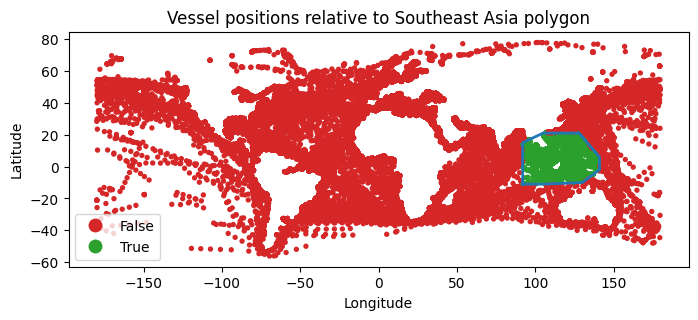

In [95]:
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np

sea_polygon_coords = [
    (92, -11), (105, -11), (130, -10), (141, -2),
    (141, 6), (128, 21), (105, 21), (92, 15), (92, -11)
]
sea_polygon = Polygon(sea_polygon_coords)

gdf = gpd.GeoDataFrame(
    vessel_positions,
    geometry=gpd.points_from_xy(vessel_positions["ais_long"], vessel_positions["ais_lat"]),
    crs="EPSG:4326"
)
gdf["in_se_asia"] = gdf.within(sea_polygon)

fig, ax = plt.subplots(figsize=(8, 6))

my_cmap = ListedColormap(["tab:red", "tab:green"])  # [False, True]

x, y = sea_polygon.exterior.xy
ax.plot(x, y, linewidth=2)

gdf.plot(ax=ax, column="in_se_asia", markersize=8, legend=True, cmap=my_cmap)

ax.set_title("Vessel positions relative to Southeast Asia polygon")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [104]:
inside_pts = gdf[gdf["in_se_asia"]].copy()

imos_inside = (
    inside_pts["imo"]
    .dropna()
    .astype(int)
    .unique()
)

print(f"{imos_inside.shape[0]} unique vessels inside the polygon")

display(imos_inside)

2930 unique vessels inside the polygon


array([1014254, 1014591, 1014931, ..., 9919204, 9920667, 9957646],
      shape=(2930,))